In [1]:
from IPython.core.debugger import set_trace
import unittest
tc = unittest.TestCase('__init__')

import numpy as np
from numpy.linalg import inv

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use = "default"
# mathjax docs: https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference

In [2]:
def p(*args):
    for arg in args:
        print(arg)
        print(" ")

# The Problem

Given $A \in \mathbb{R}^{mxn} \text{ and } b \in \mathbb{R}^n$ in the equation:

$Ax = b$
  
We want to solve for $x$

In [82]:
def ex_1():
    return (np.array([
        [4, -1, 2 ,-1],
        [2, 6, 3, -3],
        [1, 1, 5, 0],
        [1, -1, 4, 7]
    ], dtype=np.float64), 
    np.array([[-8, -20, -2, 4]], dtype=np.float64).T,
    np.array([[2, 2, 3, -7]], dtype=np.float64).T)


def ex_2():
    # slide 115
    return (
        np.array([
            [.2, .1, 1, 1, 0],
            [.1, 4, -1, 1, -1],
            [1, -1, 60, 0, -1],
            [1, 1, 0 , 8, 4],
            [0, -1, -2, 4, 700]            
        ]),
        np.array([1,2,3,4,5], dtype=np.float64).T,
        np.array([7.859713071, 0.4229264082, -.07359223906, -.5406430164, .01062616286], dtype=np.float64).T
    )

def ex_3():
    return (
        np.array([
            [4., 3., 0.],
            [3., 4., -1.],
            [0., -1., 4.]
        ]),
        np.array([24., 30., -24.]),
        np.array([3, 4, -5])
    )

def ex_4():
    return (
        np.array([
            [3.3330, 15920, -10.333],
            [2.2220, 16.710, 9.6120],
            [1.5611, 5.1791, 1.6852]
        ]),
        np.array([15913, 28.544, 8.4254]),
        np.array([1, 1, 1])
    )

def ex(number):
    if number == 1:
        return ex_1()
    elif number == 2:
        return ex_2()
    elif number == 3:
        return ex_3()
    elif number == 4:
        return ex_4()

In [4]:
def run_test(example_num, generate_plot, methods, iterations=-1):
    if not isinstance(methods, list):
        raise Exception("parameter `methods` must be a list of method declarations.")
        
    A, b, x = ex(example_num)
    errors = []
    max_err_length = -np.inf
    for method in methods:
        x, iter_vals = np.array(method(A, b, iterations))
        error = x - np.array(iter_vals)
        errors.append(error)

    if generate_plot:
        m_names = []
        plt.figure(figsize=(12, 7))
        
        for i, e in enumerate(errors):
            method_name = " ".join(methods[i].__name__.split("_"))
            plt.plot(np.linalg.norm(e, axis=1), label=method_name)
            m_names.append(method_name)
            
        plt.legend()
        plt.ylabel("norm")
        plt.xlabel("iteration")
        plt.title(", ".join(m_names) + " (example {})".format(example_num))
        
        plt.show()
    
    return errors

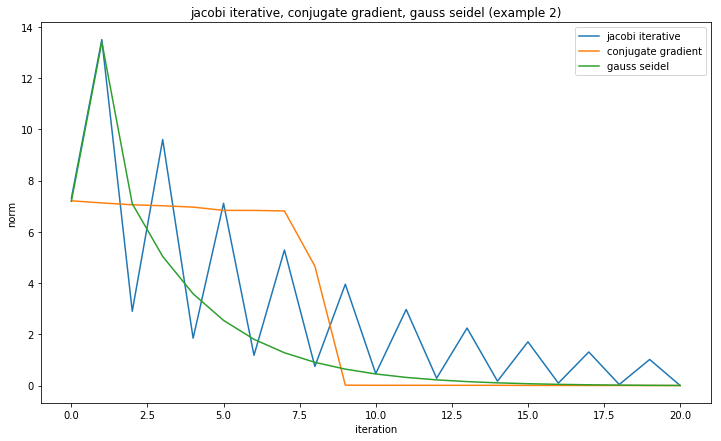

In [182]:
r = run_test(2, True, [jacobi_iterative, conjugate_gradient, gauss_seidel], 20)

# Gausse Elimination

In [136]:
def swap_rows(m, row_index_1, row_index_2):
    cpy = m.copy()
    cpy[[row_index_1, row_index_2]] = cpy[[row_index_2, row_index_1]]
    return cpy

def swap_rows_if_zero(m, b, pivot_row, pivot_col):
    if m[pivot_row, pivot_col] != 0:
        return m, b
    
    nonzero_indices = np.where(m[pivot_row:, pivot_col] != 0)
    if nonzero_indices[0].size == 0:
        return -1, -1
    m = swap_rows(m, pivot_row, nonzero_indices[0][0] + pivot_row)
    b = swap_rows(b, pivot_row, nonzero_indices[0][0] + pivot_row)
    return m, b

def swap_rows_pivot(m, b, pivot_row, pivot_col): 
    col = m[pivot_row:, pivot_col]
    max_indices = np.where(col == max(col))
    max_i = max_indices[0][0]
    if col[max_i] == 0:
        return -1, -1
    m = swap_rows(m, pivot_row, max_i + pivot_row)
    b = swap_rows(b, pivot_row, max_i + pivot_row)
    
    return m, b

def scale_matrix(m, b):
    rows = m.shape[0]
    for i in range(rows):
        row = np.array(m[i])
        m[i] = row/max(row)
        b[i] = b[i]/max(row)
    return m, b

In [140]:
def forward_elimination(A, b, partial_pivoting=True, scaled=True):
    rows, columns = A.shape
    if scaled:
        A, b = scale_matrix(A, b)
        
    for j in range(columns): 
        if partial_pivoting:
            A, b = swap_rows_pivot(A, b, j, j)
        else:
            A, b = swap_rows_if_zero(A, b, j, j)
            
        if type(A) is int:
            return "System does not have unique solution", False
        a_jj = A[j, j]
        for i in range(1 + j, rows):
            a_ij = A[i, j]
            A[i] = A[i] - (A[j]*a_ij/a_jj) 
            b[i] = b[i] - (b[j]*a_ij/a_jj)
            
    return A, b

In [119]:
# A -> n x m matrix, b -> 1 x m matrix
def backward_substitution(A, b):
    x = []
    rows, columns = A.shape
    A = A[::-1, ::-1]
    b = b[::-1]
    for i in range(rows):
        x.append((b[i] - sum(A[i, :i]))/A[i,i])
        A[:,i] = A[:, i]*x[i]
        
        
    return x[::-1]


In [120]:
def gauss(A, b, partial_pivoting=True, scaled=True):
    A, b = forward_elimination(A, b, partial_pivoting, scaled)
    if type(A) is str:
        print(A)
        return [0]
    return backward_substitution(A, b)

No Pivoting

In [147]:
A, b, x = ex_4()

p_x = gauss(A, b, partial_pivoting=False, scaled=False)
p(p_x, x)

[1.0000000000001614, 1.0, 0.9999999999999687]
 
[1 1 1]
 


Partial Pivoting

In [148]:
A, b, x = ex_4()
p_x = gauss(A, b, scaled=False)

p(p_x, x)

[1.0000000000001614, 1.0, 1.0000000000000264]
 
[1 1 1]
 


Scaled Partial Pivoting

In [174]:
A, b, x = ex_3()
p_x = gauss(A, b)

p(p_x, x)

[2.999999999999999, 4.000000000000001, -4.999999999999999]
 
[ 3  4 -5]
 


# Jacobi Iterative Method

In [7]:
def jacobi_iterative(A, b, num_iterations = -1):
    D = np.diagflat(np.diag(A))
    R = A - D
    L = np.tril(R)
    U = np.triu(R)
    inverse_D = inv(D)
    
    converg_thresh = .001
    error = np.inf
    prev_x = np.ones(b.shape)
    iterations = [prev_x]
    i = 0
    
    while i < num_iterations if num_iterations > 0 else error > converg_thresh:
        x = inverse_D @ (b - (R @ prev_x))
        iterations.append(x)
        error = np.linalg.norm(x - prev_x) / np.linalg.norm(x)
        prev_x = x
        i += 1
    
    return x, iterations

In [8]:
# slide 85/86
A = np.array([
    [4, 3, 0],
    [3, 4, -1],
    [0, -1, 4]
])
b = np.array([24, 30, -24])
x = np.array([3,4,-5])

p("Estimation:", jacobi_iterative(A,b, 3)[0], "x:", x)

Estimation:
 
[ 4.40625  5.875   -5.46875]
 
x:
 
[ 3  4 -5]
 


# Gauss-Seidel

In [9]:
def gauss_seidel(A, b, num_iterations = -1):
    L = np.tril(A)
    U = A - L
    x0 = np.random.random(b.shape)
    inv_L = inv(L) 
    
    converg_thresh = .001
    error = np.inf
    prev_x = np.ones(b.shape)
    iterations = [prev_x]
    i = 0
    while i < num_iterations if num_iterations > 0 else error > converg_thresh:
        x = inv_L @ (b - (U @ prev_x))
        iterations.append(x)
        error = np.linalg.norm(x - prev_x) / np.linalg.norm(x)
        prev_x = x
        i += 1
    
    
    return x, iterations

In [10]:
# slide 85/86
A = np.array([
    [4, 3, 0],
    [3, 4, -1],
    [0, -1, 4]
])
b = np.array([24, 30, -24])
x = np.array([3,4,-5])

p("Estimation:", gauss_seidel(A, b)[0], "x:", x)

Estimation:
 
[ 3.0083819   3.99301508 -5.00174623]
 
x:
 
[ 3  4 -5]
 


# Successive Over-Relaxation

In [11]:
def successive_over_relax(A, b, w, num_iterations = -1):
    D = np.diagflat(np.diag(A))
    L = np.tril(A, -1)
    U = np.triu(A, 1)
    
    converg_thresh = .001
    
    error = np.inf
    i = 0
    prev_x = np.ones(b.shape)
    while i < iterations if num_iterations > 0 else error > converg_thresh:
        # https://en.wikipedia.org/wiki/Successive_over-relaxation
        x = inv(D + (w * L)) @ ((w * b) - (((w * U) + ((w-1)*D)) @ prev_x))
        error = np.linalg.norm(x - prev_x) / np.linalg.norm(x)
        prev_x = x
        i += 1
    
    return x

In [12]:
# slide 85/86
A = np.array([
    [4, 3, 0],
    [3, 4, -1],
    [0, -1, 4]
])
b = np.array([24, 30, -24])
x = np.array([3,4,-5])

p("Estimation:", successive_over_relax(A, b, 1.5), "x:", x)

Estimation:
 
[ 2.99992303  3.99949167 -4.99838257]
 
x:
 
[ 3  4 -5]
 


# Iterative Refinement  

In [183]:
def iterative_refinement(A, b, method, num_iterations=2):
    x = np.array(method(A,b)) 
    for k in range(num_iterations):
        r = b - A @ x
        print(r)
        y = np.array(method(A, r))
        print(y)
        x = x + y
    
    return x

A, b, x = ex_3()
x_ref = iterative_refinement(A, b, gauss)

p("estimated:", x_ref, "actual", x)

[ 0.0000000e+00  0.0000000e+00 -8.8817842e-16]
[ 4.44089210e-16 -5.92118946e-16 -1.03620816e-15]
[0. 0. 0.]
[0. 0. 0.]
estimated:
 
[ 3.  4. -5.]
 
actual
 
[ 3  4 -5]
 


# Conditioned Conjugate Gradient

In [14]:
def conjugate_gradient(A, b, num_iterations = -1):
    x = np.ones(b.shape)
    iterations = [x]
    prev_r = b - (A @ x)
    v = prev_r
    i = 0
    while i < num_iterations if num_iterations > 0 else not np.allclose(prev_r, np.zeros(prev_r.shape)):
        Av = A @ v
        
        t = (prev_r.T @ prev_r) / (v.T @ Av)
        x = x + (t * v)
        iterations.append(x)
        
        r = prev_r - (t * Av)
        s = (r.T @ r) / (prev_r.T @ prev_r)
        v = r + (s * v)
        
        prev_r = r
        
        i += 1
    
    return x, iterations

In [15]:
p("Estimation:", conjugate_gradient(A, b)[0], "x:", x)

Estimation:
 
[ 3.  4. -5.]
 
x:
 
[ 3  4 -5]
 


In [16]:
def cc_gradient(C, A, b, num_iterations = -1):
    x = np.ones(b.shape)
    r = b - (A @ x)
    iterations = [x]
    prev_w = inv(C) @ r
    v = inv(C.T) @ prev_w
    i = 0
    while i < num_iterations if num_iterations > 0 else not np.allclose(r, np.zeros(r.shape)):
        Av = A @ v
        
        t = (prev_w.T @ prev_w) / (v.T @ Av)
        x = x + (t * v)
        iterations.append(x)
        
        r = r - (t * Av)
        
        w = inv(C) @ r
        s = (w.T @ w) / (prev_w.T @ prev_w)
        v = (inv(C.T) @ w) + (s * v)
        
        prev_w = w
        
        i += 1
    
    return x, iterations

In [17]:
p("Estimation:", cc_gradient(np.diagflat(np.diag(A)), A, b)[0], "x:", x)

Estimation:
 
[ 3.  4. -5.]
 
x:
 
[ 3  4 -5]
 
